<a href="https://colab.research.google.com/github/Shopping-Yuan/bert_project/blob/main/classification/bert_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 安裝keras-bert函式庫
!pip -q install keras-bert==0.81.0 
!pip -q install keras-transformer==0.33.0
!gdown --id "1SQJZmilEwCqffyb4MbQBPlr3-N20sLnS" --output chinese_wwm_L-12_H-768_A-12.zip
!unzip  chinese_wwm_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1SQJZmilEwCqffyb4MbQBPlr3-N20sLnS
To: /content/chinese_wwm_L-12_H-768_A-12.zip
382MB [00:05, 69.1MB/s]
Archive:  chinese_wwm_L-12_H-768_A-12.zip
   creating: publish/
  inflating: publish/vocab.txt       
  inflating: publish/bert_model.ckpt.index  
  inflating: publish/bert_model.ckpt.data-00000-of-00001  
  inflating: publish/bert_config.json  
  inflating: publish/bert_model.ckpt.meta  


In [2]:
# SEQ_LEN: 取原文的多少個字, 建議至少256以上, 512是最大值, 但是會導致模型太大而RAM不夠用(超過的"後文"會被刪去)
SEQ_LEN = 512

In [3]:
# 讀取預訓練模型
import os
pretrained_path = "publish"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
# 模型預訓練的字表
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [4]:
# 設置BERT的編碼器
# BERT 透過 Subword 的方式讓辭典長度最大就是 21128
token_dict = {}
with open(vocab_path, 'r', encoding='utf8') as f:
    for line in f.readlines():
        token = line.strip()
        token_dict[token] = len(token_dict)
print("辭典長度:", len(token_dict))
#注意單字表是從1開始和Token的值會有差異
from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict)

辭典長度: 21128


In [5]:
#載入jieba字典
import jieba.analyse
import os
from urllib.request import urlretrieve
if not os.path.exists ("dict.txt.big"):
  url = "https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big"
  urlretrieve(url, "dict.txt.big")
jieba.set_dictionary ('dict.txt.big')
punct = set(u''':!),.:;?]}¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘-—_…~/ －＊➜■─★☆=@<>◉é''')

In [6]:
#此函數對文章進行分詞,並得到bert的二項輸入
import numpy as np
def tokenize_data(x):
  # cut with jieba 且移除標點符號
  words = "".join(filter(lambda x: x not in punct, jieba.cut(x)))
  # 文章頭尾各截一半
  if len(words)>= SEQ_LEN:
    words_head = words[:round(SEQ_LEN/2)+1]
    words_tail = words[-int(SEQ_LEN/2)+2:]
    ids, segments = tokenizer.encode(first=words_head, second=words_tail, max_len=SEQ_LEN)
    ids = np.array(ids)
    segments = np.array(segments, dtype ='f2')
  else :
    ids, segments = tokenizer.encode(words, max_len=SEQ_LEN)
    ids = np.array(ids)
    segments = np.array(segments, dtype ='f2')
  return ids, segments

In [7]:
#此函數匯整每一篇文章的二項輸入,將兩種輸入分開成二個list
import pandas as pd
def prepare_input(x):
  x_tokenize = np.array(x.apply(tokenize_data)) 
  en_r = []
  seq_r = []
  for n in range(x_tokenize.shape[0]):
    en_r.append(x_tokenize[n][0])
    seq_r.append(x_tokenize[n][1])
  train_list_x = [np.array(en_r), np.array(seq_r)]
  return train_list_x

In [28]:
#讀取資料(由MariaDB資料庫)
!pip install pymysql
# !gdown --id "1Wv0l3XtyWd3DI82jx0oQpVC945WDIxd7" --output LinkMariaDB.py

In [29]:
# 連 Server 依日期分別抓取訓練集和測試集
# import LinkMariaDB 
# hostName = '34.80.102.35'
# portNum = 3306
# DBName = 'db_blogler'
# username = 'shop'
# password = '12345678'
# CharSet = "utf8"

# DB = LinkMariaDB.OpMariaSQL(hostName, portNum, username, password, DBName, CharSet)
# total_df = pd.DataFrame(DB.IntputFindCmd(f"SELECT * FROM main WHERE label_1 IS NOT NULL LIMIT 2000"))

In [30]:
#讀取資料(由檔案)
!gdown --id "1gG3zQlEjbjPpa4ykg6r2d_UIslPqSwL9" --output multiple_classification.csv
total_df = pd.read_csv("multiple_classification.csv")

Downloading...
From: https://drive.google.com/uc?id=1gG3zQlEjbjPpa4ykg6r2d_UIslPqSwL9
To: /content/multiple_classification.csv
14.0MB [00:00, 30.1MB/s]


In [31]:
total_df

,medium_id,title,content,label_1,label_2,label_3,label_4,label_5,label_6,label_7
0,e2a59b7849ce,跨平台開發的一些姿勢,跨平台開發的一些姿勢Cordova、Xamarin、NativeScript、React N...,1,0,0,0,0,0,0
1,2da1d20c2678,A/B testing 你真的做對了嗎？產品開發團隊必懂的五大方法論,A/B testing 你真的做對了嗎？產品開發團隊必懂的五大方法論A/B testing ...,0,0,0,1,0,0,0
2,132e6d31f85b,如何從零開始自學程式開發：我花了三年，從香港商學院來到紐約與矽谷實習的旅程,如何從零開始自學程式開發：我花了三年，從香港商學院來到紐約與矽谷實習的旅程三年前我來到紐約實...,1,0,0,0,0,0,0
3,75bf69a46016,軟體開發流程是什麼？PM與UX Designer的區別？,軟體開發流程是什麼？PM與UX Designer的區別？大家好，這是四神湯的第一篇的文章，就...,0,0,1,1,0,0,0
4,1e332f83d343,為工程師文件而生的協作平台：HackMD 開發故事,為工程師文件而生的協作平台：HackMD 開發故事批踢踢八卦板上有人說，他修了資工系的課，發...,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1995,b46565e78dc2,庸才式管理,庸才式管理作為一名庸才，你在工作的時候思考的當然不會是你對人類、對社會、對他人、甚至對於你所...,0,0,0,1,0,0,1
1996,78d227b6a5e6,Mentor系列-我的啟蒙恩師，把時間花在部屬身上,Mentor系列-我的啟蒙恩師，把時間花在部屬身上前四篇關於Mentor的文章我分別分享了四...,0,0,0,1,0,0,1
1997,57208190cc50,指導部屬的正確方法,指導部屬的正確方法不久前，有個剛升任主管的朋友找我聊關於部門帶領的問題，他劈頭的第一句就說：...,0,0,0,1,0,0,1
1998,e007c2d2303d,Drone Cloud 初體驗?—?自動化部屬 Nodejs Function 到 AWS?...,Drone Cloud 初體驗 — 自動化部屬 Nodejs Function 到 AWS ...,1,0,0,0,0,0,0


In [33]:
#準備輸入
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(total_df["content"],total_df.iloc[:,3:10],test_size = 0.2, random_state=0)
train_list_x = prepare_input(train_x)
test_list_x = prepare_input(test_x)
train_y = train_y.astype('float32')
test_y = test_y.astype('float32')

Building prefix dict from /content/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
Loading model cost 1.384 seconds.
Prefix dict has been built successfully.


In [34]:
#調整權重:1為該篇文章符合某類別,0為不符合該類別,由於0和1的比例差距,故調整權重
num_of_ones = np.count_nonzero(train_y == 1)
num_of_zeros = np.count_nonzero(train_y == 0)
zero_weight = (1-num_of_ones)/(num_of_ones + num_of_zeros)
one_weight = (1-num_of_zeros)/(num_of_ones + num_of_zeros)
# weight
from keras import backend as K

def weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return -1*K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [ ]:
# #不使用Adapter
# from keras_bert import load_trained_model_from_checkpoint

# model = load_trained_model_from_checkpoint(
#     config_path,
#     checkpoint_path,
#     training=False,
#     trainable=False,
#     seq_len=SEQ_LEN,
# )

In [35]:
# 使用 Adapter 來獲得比較高的準確率
from keras_bert import load_trained_model_from_checkpoint
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    use_adapter=True,
    training=True,
    trainable=['Encoder-{}-MultiHeadSelfAttention-Adapter'.format(i + 1) for i in range(layer_num)] +
    ['Encoder-{}-FeedForward-Adapter'.format(i + 1) for i in range(layer_num)] +
    ['Encoder-{}-MultiHeadSelfAttention-Norm'.format(i + 1) for i in range(layer_num)] +
    ['Encoder-{}-FeedForward-Norm'.format(i + 1) for i in range(layer_num)],
    seq_len=SEQ_LEN
)

In [36]:
#設置模型變數
import keras
Optimizer = keras.optimizers.Adam(learning_rate=0.0001)
Loss = 'binary_crossentropy'
Metrics = 'accuracy'

In [ ]:
# #不使用Adapter
# from keras.layers import SimpleRNN
# from keras import regularizers
# inputs = model.inputs[:2]
# rnn = SimpleRNN(64)(model.output)
# outputs = keras.layers.Dense(units=14, activation="softmax")(rnn)
# model = keras.models.Model(inputs, outputs)
# model.compile(
#     loss=Loss,
#     optimizer=Optimizer,
#     metrics=[Metrics]
# )

In [37]:
# 使用Adapter
# 不用拿整個詞彙的encoding, 因為這樣訓練時間一定會拉很長
# 我們直接拿整段文章的代表encoding, 也就是[CLS]的encoding
# 那層叫做 NSP-Dense

inputs = model.inputs[:2]
#加入二層全連接層 後一層為輸出層
dense1 = model.get_layer('NSP-Dense').output
dense2 = keras.layers.Dense(units=128, activation='relu')(dense1)
outputs = keras.layers.Dense(units=7, activation='sigmoid')(dense2)

model = keras.models.Model(inputs, outputs)

model.compile(
    loss=weighted_binary_crossentropy(zero_weight,one_weight),
    optimizer=Optimizer,
    metrics=[Metrics]
)

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 256, 768), ( 16226304    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 256, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

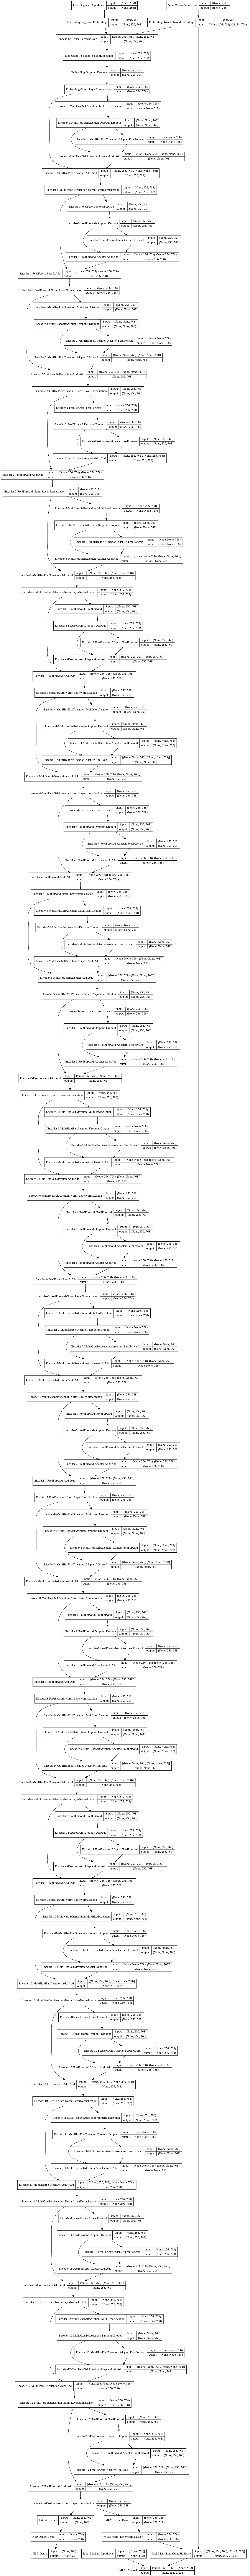

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
EPOCHS = 30
BATCH_SIZE = 8
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.fit(
    train_list_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[
    ModelCheckpoint("model.h5", save_best_only=True),
    EarlyStopping(patience=3, restore_best_weights=True)],
)

Epoch 1/30
180/180 [==============================] - 184s 924ms/step - loss: 0.1637 - accuracy: 0.1648 - val_loss: 0.1491 - val_accuracy: 0.0812
Epoch 2/30
180/180 [==============================] - 166s 920ms/step - loss: 0.1282 - accuracy: 0.2042 - val_loss: 0.1181 - val_accuracy: 0.3187
Epoch 3/30
180/180 [==============================] - 165s 919ms/step - loss: 0.1026 - accuracy: 0.3419 - val_loss: 0.1009 - val_accuracy: 0.3562
Epoch 4/30
180/180 [==============================] - 165s 918ms/step - loss: 0.0912 - accuracy: 0.4091 - val_loss: 0.0882 - val_accuracy: 0.5500
Epoch 5/30
180/180 [==============================] - 165s 917ms/step - loss: 0.0810 - accuracy: 0.4291 - val_loss: 0.0920 - val_accuracy: 0.4750
Epoch 6/30
180/180 [==============================] - 165s 919ms/step - loss: 0.0781 - accuracy: 0.4778 - val_loss: 0.0923 - val_accuracy: 0.4875
Epoch 7/30
180/180 [==============================] - 165s 917ms/step - loss: 0.0702 - accuracy: 0.4975 - val_loss: 0.0965 -

In [39]:
# 不用Adapter
# model.evaluate(test_list_x, test_y_list)

In [40]:
# 使用Adapter
model.evaluate(test_list_x, test_y)

13/13 [==============================] - 22s 1s/step - loss: 0.0765 - accuracy: 0.5125


[0.07650505751371384, 0.512499988079071]